<a href="https://colab.research.google.com/github/geekpradd/Reinforcement-Learning-Stock-Trader/blob/master/Stock%20Final%20Codes%20and%20Results/Copy_of_New_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import gym
from gym import spaces
from matplotlib import pyplot as plt
import time
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from tensorflow.keras.layers import Dense, Concatenate, Lambda, Activation
from tensorflow.keras import Input
from tensorflow import convert_to_tensor as convert
import pickle
# COLAB = False
# if not COLAB:
#     import os
#     os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
path_base = '/content/drive/My Drive/Stock/Stock/'
import os

In [2]:
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, params, train = True):
        super(StockEnv,self).__init__()
        
        self.num_stocks = params['num_stocks']
        self.min_brokerage = params['min_brokerage']
        self.brokerage_rate = params['brokerage_rate']
        self.balance_normal = params['balance_normal']
        self.shares_normal = params['shares_normal']
        self.dfs = df
        self.state_dimensions = self.num_stocks*5+1
        self.train = train

        assert len(df) == self.num_stocks, "Size of database not equal to number of stocks"

        self.max_steps = min([len(d.loc[:,'Open']) for d in self.dfs])
        self.action_space = spaces.Box(low = -1, high = 1, shape =  (1, self.num_stocks*2), dtype = np.float32)
        self.observation_space = spaces.Box(low = 0, high = 1, shape = (1, self.state_dimensions), dtype = np.float32)

    def reset(self, intial_balance = 10000, shares_held = None):

        if self.train:
            self.current_step = np.random.randint(0, self.max_steps)
        else:
            self.current_step = 0
        self.balance = intial_balance
        self.shares_held = shares_held
        if self.shares_held is None:
            self.shares_held = np.zeros((1, self.num_stocks))
        self.current_price = self.get_price()
        self.highest_price = 0
        self.net_worth = self.balance + np.sum(self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.set_high()
        self.done = False
        self.frame = np.zeros((1, self.state_dimensions))
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance,
        }
        return self.observe()
        
    def get_price(self):
        return np.array([np.random.uniform(df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]) for df in self.dfs]).reshape((1, self.num_stocks))
      
    def set_high(self):
        high = np.array([df.loc[self.current_step, 'High'] for df in self.dfs]).reshape((1, self.num_stocks))
        self.highest_price = np.maximum(self.highest_price, high)

    def observe(self):
        for i in range(self.num_stocks):
            self.frame[0, 4*i:4*i+4] = np.array([self.dfs[i].loc[self.current_step,'Open'],self.dfs[i].loc[self.current_step,'High'],self.dfs[i].loc[self.current_step,'Low'],self.dfs[i].loc[self.current_step,'Close']])/self.highest_price[0, i]
        self.frame[0, self.num_stocks*4:self.num_stocks*5] = self.shares_held/self.shares_normal
        self.frame[0, 5*self.num_stocks] = self.balance/self.balance_normal
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance
        }
        return self.frame, self.info
    
    def update_worth(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def update_balance(self, action):
        self.balance += np.sum(action[:, :self.num_stocks]*self.current_price)
        self.balance -= np.sum(action[:, self.num_stocks:]*self.current_price)

    def update_shares(self, action):
        self.shares_held -= action[:, :self.num_stocks]
        self.shares_held +=  action[:, self.num_stocks:]

    def take_action(self, action):
        self.current_price = self.get_price()
        action[:, :self.num_stocks] = np.floor(action[:, :self.num_stocks] *self.shares_held)
        action[:, self.num_stocks:] = np.floor(action[:, self.num_stocks:] * self.balance / self.current_price)
        self.set_high()
        self.update_balance(action)
        self.update_shares(action)
        reward = self.balance + np.sum(self.shares_held * self.current_price) - self.net_worth
        self.update_worth(reward)
        return reward
            
    def step(self, action):
        self.current_step += 1
        if self.current_step >= self.max_steps or self.done:
            self.done = True
            return np.zeros((1, self.state_dimensions)), 0, self.done, self.info
        if np.sum(action[:, self.num_stocks:]) > 1:
            print('gadbad')
        reward = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.05
        if self.done:
            print('snap')
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(locations, train=True):
    dfs = [pd.read_csv(location).sort_values('Date') for location in locations]
    params = {
        'num_stocks' : len(locations),
        'min_brokerage' : 30.0,
        'brokerage_rate' : 0.001,
        'balance_normal' : 1000000,
        'shares_normal' : 10000,
    }
    return StockEnv(dfs, params, train)

In [3]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = random.sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]
        
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [4]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.cap = params['cap']
        self.tau = params['tau']
        self.online_actor = self.build_model()
        self.target_actor = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=(self.state_dimensions, ))
        x = Dense(512, activation = 'relu')(inputs)
        x = Dense(256, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        sell = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        buy = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        final_buy = Activation(tf.keras.activations.softmax)(buy)*tf.math.minimum(self.cap, tf.reduce_sum(buy, axis = -1, keepdims = True))
        model = keras.Model(inputs = inputs, outputs = tf.concat([sell, final_buy], axis = -1))
        # model.summary()
        return model
    
    def online_get_action(self, state):
        return self.online_actor(convert(state))

    def target_get_action(self, state):
        return self.target_actor(convert(state))

    def save(self):
        self.online_actor.save(path_base + 'online_actor.h5')
        self.target_actor.save(path_base + 'target_actor.h5')
    
    def load(self):
        self.online_actor = keras.models.load_model(path_base + 'online_actor.h5')
        self.target_actor = keras.models.laod_model(path_base + 'target_actor.h5')

    def merge(self):
        self.target_actor.set_weights(self.tau*np.array(self.online_actor.get_weights())
                                                                    + (1-self.tau)*np.array(self.target_actor.get_weights()))

class Critic:
    def __init__(self, params):
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.optimizer = params["critic_optimizer"]
        self.tau = params['tau']
        self.critic_online = self.build_model()
        self.critic_target = self.build_model()
        self.critic_online.set_weights(self.critic_target.get_weights())

    def build_model(self):
        input_a = Input(shape = (self.state_dimensions, ))
        input_b = Input(shape = (2*self.action_dimensions, ))
        input = Concatenate(axis = -1)([input_a, input_b])
        x = Dense(512, activation = 'relu')(input)
        x = Dense(256, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        output = Dense(1)(x)
        model = keras.Model(inputs=[input_a, input_b], outputs = output)
        model.compile(loss='mse', optimizer = keras.optimizers.Adam(learning_rate = 0.001))
        # model.summary()
        return model

    def save(self):
        self.critic_online.save(path_base + 'critic_online.h5')
        self.critic_target.save(path_base + 'critic_target.h5')

    def load(self):
        self.critic_online = keras.models.load_model(path_base + 'critic_online.h5')
        self.critic_target = keras.models.load_model(path_base + 'critic_target.h5')

    def get_qvalues(self, state_array, action_array, online=True):
        if online:
            return self.critic_online([convert(state_array), convert(action_array)])
        else:
            return self.critic_target([convert(state_array), convert(action_array)])

    def call(self, state_tensor, action_tensor):
        return self.critic_online([state_tensor, action_tensor])
    
    def merge(self):
        self.critic_target.set_weights(self.tau*np.array(self.critic_online.get_weights())
                                                                    + (1-self.tau)*np.array(self.critic_target.get_weights()))

In [5]:
class Agent:
    def __init__(self, params, train = True, resume = True):
        self.train = train
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayMemory(params["buffer_size"])
        self.state_dimensions = params["state_dimensions"]
        self.prev_states = params["prev_states"]
        self.one_dimension = params["one_dimension"]
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.action_range = params["output_range"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.cap = params['cap']
        self.num_steps = 0
        self.curr_state = np.zeros((self.prev_states,self.one_dimension))
        self.num_states = 0
        self.noise_func =  OrnsteinUhlenbeckActionNoise(mu=np.zeros(2*params["action_dimensions"]))
        if resume:
            self.load()

    def agent_start(self):
        self.curr_state = np.zeros((self.prev_states,self.one_dimension))
        self.num_states = 0

    def clip_action(self, action):
        action = np.clip(action, 0, self.action_range)
        total = np.sum(action, axis = -1, keepdims = True)
        if not total:
            return action
        action = action*np.minimum(total, self.cap)/total
        return action
        
    def agent_step(self, reward, observation):
        
        self.num_states += 1
        self.curr_state[:-1, :] = self.curr_state[1:, :].copy()
        self.curr_state[-1, :] = observation
        state = np.reshape(self.curr_state, (1, self.state_dimensions))

        if self.num_states < self.prev_states:
            action = np.zeros((1,self.action_dimensions*2))
            self.prev_action = action
            self.prev_state = np.reshape(self.curr_state, [1,self.state_dimensions])
            return self.prev_action

        if self.num_states == self.prev_states:
            action = self.actor.online_get_action(state)
            if self.train:
                action = self.clip_action(action + self.noise_func())
            else:
                action = self.clip_action(action)
            self.prev_state = state
            self.prev_action = action
            return self.prev_action

        if self.train:
            replay = (self.prev_state, self.prev_action, reward, state)
            self.buffer.append(replay)
            
        action = self.actor.online_get_action(state)
        if self.train:
            action = self.clip_action(action + self.noise_func())
            self.run()
        else:
            action = self.clip_action(action)
        self.prev_action = action
        self.prev_state = state
        return self.prev_action 
    
    def save(self):
        self.actor.save()
        self.critic.save()
        data = (self.buffer, self.num_steps, self.noise_func)
        with open (path_base + 'auxiliary.pkl', 'wb') as f:
            pickle.dump(data, f)
        
        print('Saved Successfully!')

    def load(self):
        self.actor.load()
        self.critic.load()
        with open (path_base + 'auxiliary.pkl', 'rb') as f:
            data = pickle.load(f)
        self.buffer, self.num_steps, self.noise_func = data
        print('Loaded Successfully!')
    
    def run(self):
        self.num_steps += 1
        size = min(self.batch_size, self.buffer.size)
        batch = self.buffer.sample(size)
        prev_states = np.array([x[0] for x in batch]).reshape((-1, self.state_dimensions))
        prev_actions = np.array([x[1] for x in batch]).reshape((-1, 2*self.action_dimensions))
        rewards = np.array([x[2] for x in batch]).reshape((-1, 1))
        states = np.array([x[3] for x in batch]).reshape((-1, self.state_dimensions))

        target_actions = self.actor.target_get_action(states)
        q_values = self.discount*self.critic.get_qvalues(states, target_actions, False)
        q_values += rewards
        self.critic.critic_online.fit([prev_states, prev_actions], q_values, epochs = 2, verbose=0)

        prev_state_tensor = convert(prev_states)
        prev_action_tensor = convert(prev_actions)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(prev_action_tensor)
            value = self.critic.call(prev_state_tensor, prev_action_tensor)
            action = self.actor.online_actor(prev_state_tensor)
        gradient = -tape.gradient(value, prev_action_tensor)
        gradient = tf.cast(gradient, tf.float32)
        gradient_actor = tape.gradient(action, self.actor.online_actor.trainable_weights, gradient)
        gradient_actor = list(np.array(gradient_actor)/size)

        self.optimizer.apply_gradients(zip(gradient_actor, self.actor.online_actor.trainable_weights))
        self.critic.merge()
        self.actor.merge()
        del tape

        if self.num_steps % self.save_frequency == 0:
            self.save()

In [6]:
epochs_per_iter = 10

def train(agent, env, epochs, profits, balances, shares, actions):

    steps_per_epoch = 2000
    
    for epoch in tqdm(range(epochs, epochs + epochs_per_iter+1)):

        cumm_profit = 0
        observation, info = env.reset()
        shares[epoch, 0, :] = info['shares_held']
        balances[epoch, 0] = info['balance']
        agent.agent_start()
        action = agent.agent_step(0,observation)
        actions[epoch, 0, :] = action

        for i in tqdm(range(steps_per_epoch)):

            observation, reward, done, info = env.step(action)
            shares[epoch, i+1, :] = info['shares_held']
            balances[epoch, i+1] = info['balance']
            cumm_profit += reward
            profits[epoch, i] = cumm_profit
            if done:
                break
            action = agent.agent_step(reward, observation)
            # if not np.isfinite(action).all():
            #     for att in vars(agent):
            #         print (att, getattr(agent,att))
            #     print('--------------------------------------------------------------------------------------------------')
            #     for att in vars(agent.actor):
            #         print (att, getattr(agent.actor,att))
            #     print('--------------------------------------------------------------------------------------------------')
            #     # print(--------------------------------------------------------------------------------------------------------)
            #     for att in vars(agent.critic):
            #         print (att, getattr(agent.critic,att)) 
            #     print('--------------------------------------------------------------------------------------------------')
            #     #print(--------------------------------------------------------------------------------------------------------)
            #     for att in vars(env):
            #         print (att, getattr(env,att))
            #     print('--------------------------------------------------------------------------------------------------')
            #     #     print(--------------------------------------------------------------------------------------------------------)
            #     break
            #     for name, value in globals().items():
            #          print(name, value)
            actions[epoch, i+1, :] = action

        if epoch % 10 == 0:
            data = epoch, profits, shares, balances, actions
            with open(path_base + 'graph.pkl', 'wb') as f:
                pickle.dump(data, f)

In [7]:
AGENT_PARAMS = {
	"output_range": 1,
	"prev_states" : 20,
	"one_dimension" : 11,
	"state_dimensions" : 20*11,
	"action_dimensions": 2,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0001),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.00005),
	"batch_size": 64,
	"buffer_size":100000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 10000,
	'cap' : 0.9,
}

In [10]:
stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
files = [path_base + 'M.csv', path_base + 'PCG.csv']
env = create_stock_env(files,train= True)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS, train = True,resume = False)
print(agent.num_steps)

0


In [ ]:
for f in stocks:
    index = random.sample(range(12), 2)
    files = [path_base + stocks[index[0]], path_base + stocks[index[1]]]
    env = create_stock_env(files,train= True)
    with open(path_base + 'graph.pkl', 'rb') as fi:
        data = pickle.load(fi)
    epochs, profits, shares, balances, actions = data
    train(agent, env, epochs, profits, balances, shares, actions)
    epochs += epochs_per_iter

In [21]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs,epochs//10):
    plt.plot(profits[i])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()
# epochs = 0
# steps_per_epoch = 2000
# profits = np.zeros((2000, steps_per_epoch+1))
# shares = np.zeros((2000, steps_per_epoch +1 , 2))
# balances = np.zeros((2000, steps_per_epoch+1))
# actions = np.zeros((2000, steps_per_epoch+1, 4))
# data = (epochs, profits, shares, balances, actions)
# with open(path_base + 'graph.pkl', 'wb') as f:
#     pickle.dump(data, f)

# with open(path_base + 'graph.pkl', 'rb') as fi:
#         data = pickle.load(fi)
# epochs, profits, shares, balances, actions = data
# print(epochs)


0


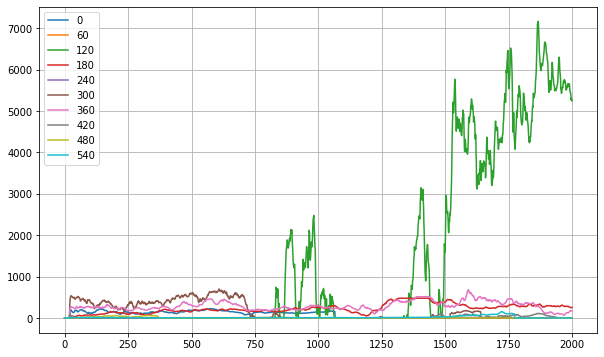

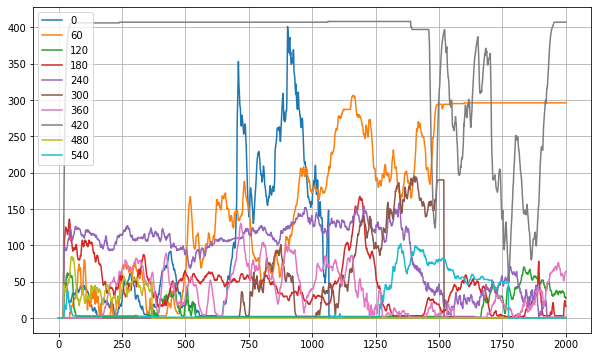

In [ ]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(shares[i, :, 0])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(shares[i, :, 1])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

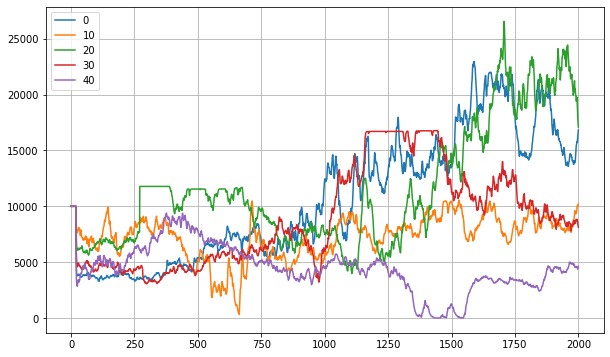

In [ ]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//5):
    plt.plot(balances[i])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

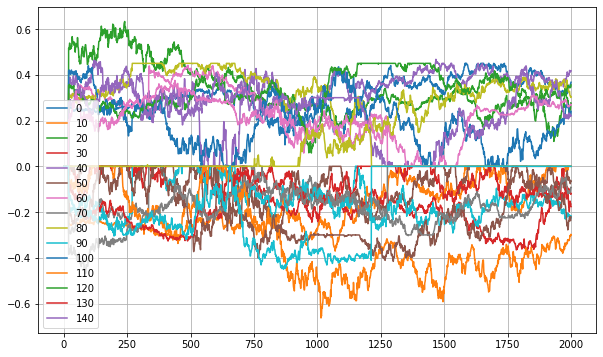

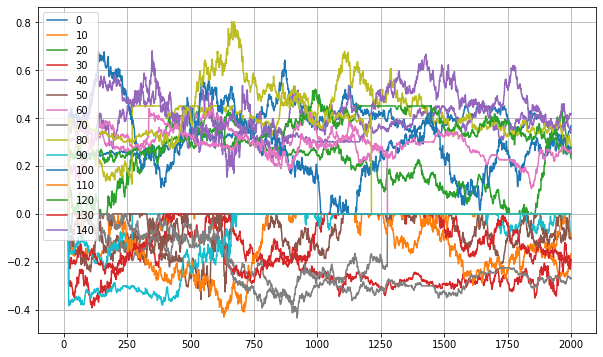

In [ ]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(actions[i, :, 0])
    plt.plot(-actions[i,:, 2])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(actions[i, :, 1])
    plt.plot(-actions[i,:, 3])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

In [ ]:
files = np.random.choice(stocks,2)
print(files)
files = ['AAPL.csv','PCG.csv']
def test(env,agent):
    print(agent.num_steps)
    max_steps = env.max_steps
    profitst = np.zeros(max_steps)
    balancest = np.zeros( max_steps + 1)
    sharest = np.zeros((max_steps+1, agent.action_dimensions))
    actionst = np.zeros((max_steps+1, agent.action_dimensions*2))
    profit = 0
    observation, info = env.reset(intial_balance = 20000)
    balancest[0] = info['balance']
#         print(info['balance'])
    sharest[0] = info['shares_held']
#         print(info['shares_held'])
    agent.agent_start()
    action = agent.agent_step(0,observation)
    actionst[0] = action

    for i in tqdm(range(max_steps)):
        observation, reward, done, info = env.step(action)
        profit += reward
        profitst[i] = env.net_worth
        balancest[i+1] = info['balance']
        sharest[i+1] = info['shares_held']
        #print(action)
        #print('state',agent.state)
        if done:
            break
#         if i%500 ==0:
#             print(i)
        action = agent.agent_step(reward, observation)
        actionst[i+1] = action
#             print('o',action)
    print(profitst[i-1])
#     print('Completed' + str(count) + 'values')

    return profitst, balancest, sharest, actionst


['INFY.csv' 'AMZN.csv']


In [ ]:
stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
files = np.random.choice(stocks,2)
files[0] = files[1]
print(files)
env = create_stock_env(files, train = False)
agent = Agent(AGENT_PARAMS, train = False, resume = True)
profitst1, balancest1, sharest1, actionst1 = test(env,agent)

env = create_stock_env(files, train = False)
agent = Agent(AGENT_PARAMS, train = True
              , resume = False)
profitst, balancest, sharest, actionst = test(env,agent)

df1 = pd.read_csv(files[0])
df2 = pd.read_csv(files[1])
plt.figure(figsize = [15, 10])

plt.plot(profitst1[:])
plt.plot(profitst[:])
plt.plot(df1.loc[:,'High']*20000/df1.loc[0,'Low'])
plt.plot(df2.loc[:,'High']*20000/df2.loc[0,'Low'])
plt.grid()
plt.title('profit')
plt.legend(['agent','random agent','follow '+files[0],'follow '+files[1]])
plt.show()

['PNB.csv' 'PNB.csv']
loading
Successfully Loaded


  0%|          | 0/2572 [00:00<?, ?it/s]

0
current_step 0


  0%|          | 0/2572 [00:00<?, ?it/s]

11572.591679113308
0
current_step 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

 74%|███████▍  | 1898/2572 [01:27<00:29, 23.10it/s]

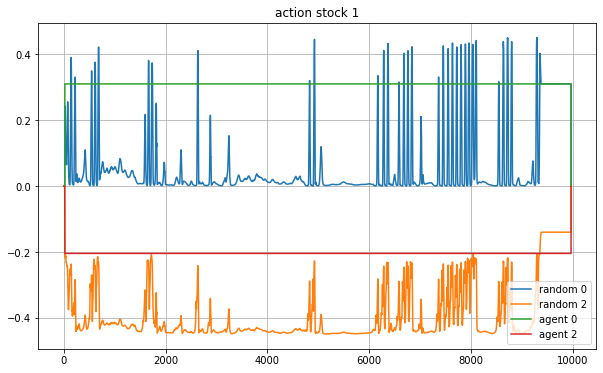

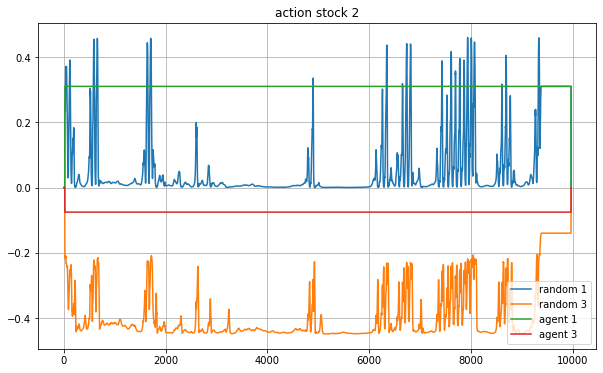

In [ ]:
plt.figure(figsize = [10, 6])
plt.plot(actionst[:,0])
plt.plot(-actionst[:,2])
plt.plot(actionst1[:,0])
plt.plot(-actionst1[:,2])
plt.legend(['random 0','random 2','agent 0','agent 2'])
plt.grid()
plt.title('action stock 1')
plt.show()
    
plt.figure(figsize = [10, 6])
plt.plot(actionst[:,1])
plt.plot(-actionst[:,3])
plt.plot(actionst1[:,1])
plt.plot(-actionst1[:,3])
plt.grid()
plt.legend(['random 1','random 3','agent 1','agent 3'])
plt.title('action stock 2')
plt.show()

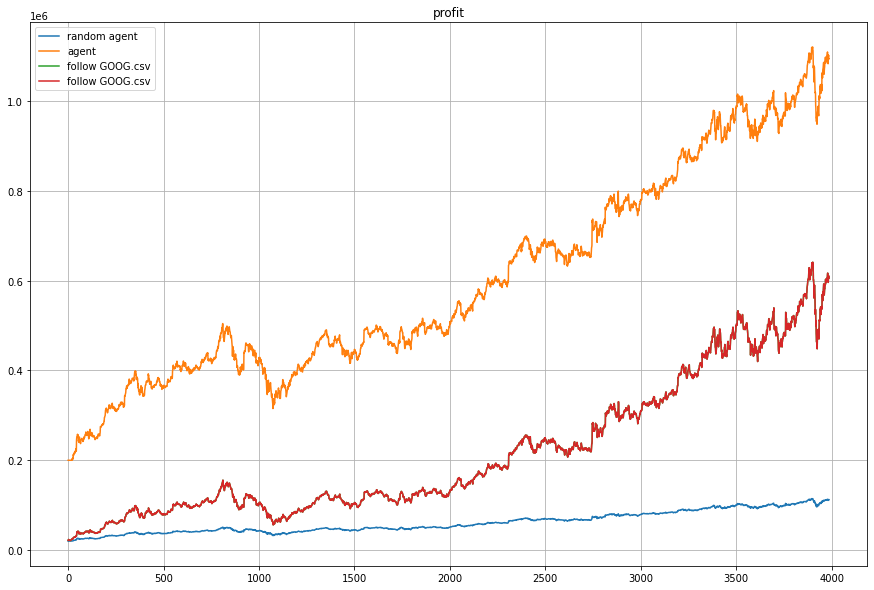

In [ ]:
df1 = pd.read_csv(files[0])
df2 = pd.read_csv(files[1])
plt.figure(figsize = [15, 10])
plt.plot(profitst[:])
plt.plot(profitst1[:]*10)
plt.plot(df1.loc[:env.max_steps,'High']*20000/df1.loc[0,'Low'])
plt.plot(df2.loc[:env.max_steps,'High']*20000/df2.loc[0,'Low'])
plt.legend(['random agent','agent','follow '+files[0],'follow '+files[1]])
plt.grid()
plt.title('profit')
plt.show()

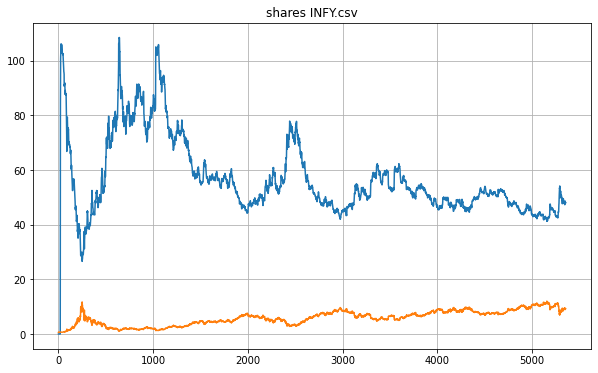

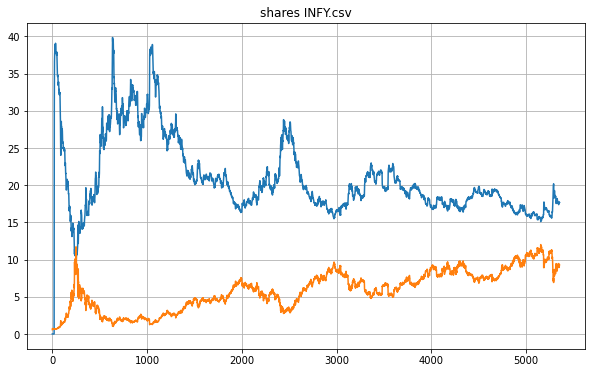

In [ ]:
for count,i in enumerate(files):
    plt.figure(figsize = [10, 6])
    plt.plot(sharest[:, count]*0.01)
    df = pd.read_csv(i)
    plt.plot(df['Open'])
    plt.grid()
    plt.title('shares '+i)
    plt.show()

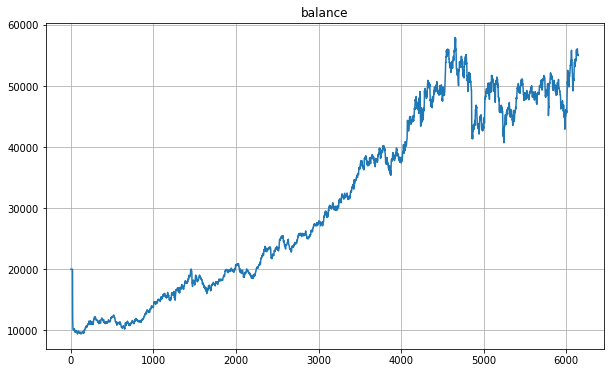

In [ ]:
plt.figure(figsize = [10, 6])
plt.plot(balancest[:])
plt.grid()
plt.title('balance')
plt.show()

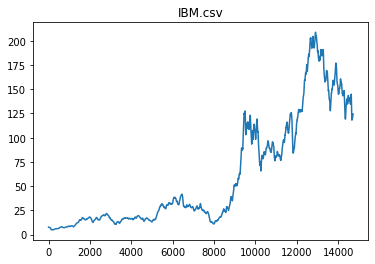

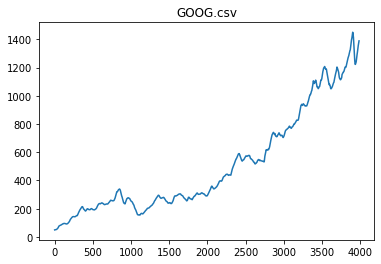

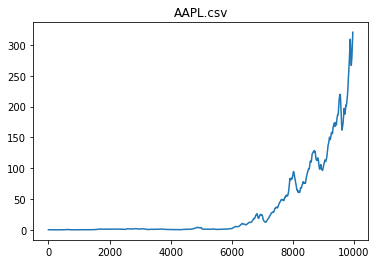

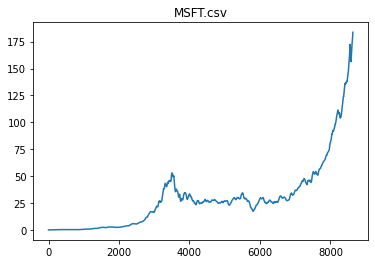

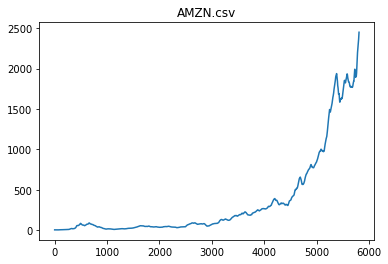

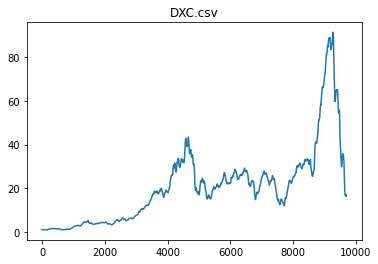

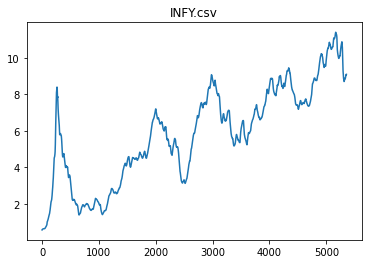

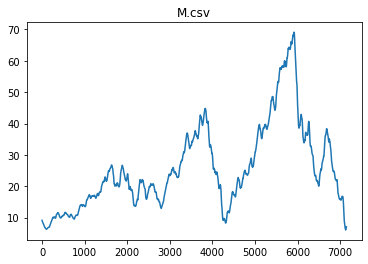

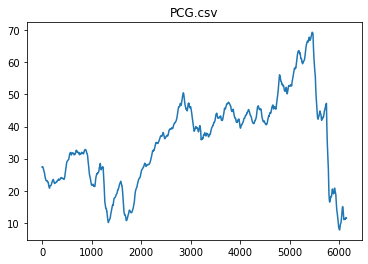

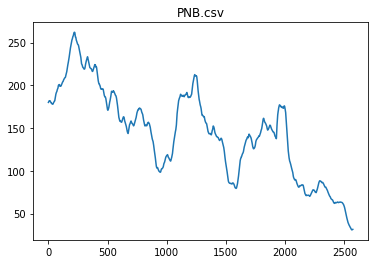

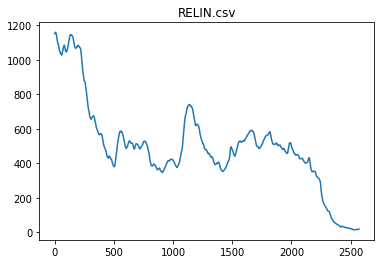

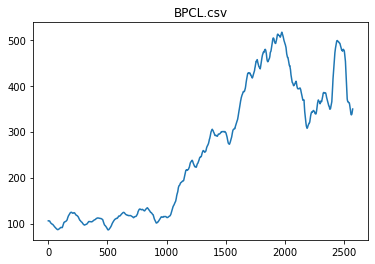

In [ ]:
for i in stocks:
    df = pd.read_csv(i)
    #plt.plot(df['Open'])
    x = list(df['Open'])
    for j in range(1,len(x)):
        x[j] = 0.05*x[j] + 0.95*x[j-1]
    plt.plot(x)
    plt.title(i)
    plt.show()

    
#dxc,m,pcg   
#IBM
#infy
#google,aapl,msft,amzn

In [ ]:
for att in vars(agent):
    print (att, getattr(agent,att))
print('--------------------------------------------------------------------------------------------------')
for att in vars(agent.actor):
    print (att, getattr(agent.actor,att))
print('--------------------------------------------------------------------------------------------------')
# print(--------------------------------------------------------------------------------------------------------)
for att in vars(agent.critic):
    print (att, getattr(agent.critic,att)) 
print('--------------------------------------------------------------------------------------------------')
#print(--------------------------------------------------------------------------------------------------------)
for att in vars(env):
    print (att, getattr(env,att))
print('--------------------------------------------------------------------------------------------------')
#     print(--------------------------------------------------------------------------------------------------------)

for name in vars().keys():
    print(name)

back_state 1
train True
actor <__main__.Actor object at 0x7f52b4daaf90>
critic <__main__.Critic object at 0x7f52b409f810>
buffer <__main__.ReplayMemory object at 0x7f52a6b560d0>
state_dimensions 16
action_dimensions 3
discount 0.99
action_range 1
save_frequency 5000
batch_size 64
optimizer <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f52b45c2ed0>
cap 0.9
num_steps 0
state [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
have_state 1
noise_func OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0.], sigma=0.3)
--------------------------------------------------------------------------------------------------
output_range 1
state_dimensions 16
action_dimensions 3
cap 0.9
actor <tensorflow.python.keras.engine.training.Model object at 0x7f52b4b90150>
--------------------------------------------------------------------------------------------------
state_dimensions 16
action_dimensions 3
optimizer <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f52b405f090>
tau 0